# The project is about supervised classification using neural network in pytorch. I use spine dataset for this project.

In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

import torch
import torch.nn as nn

In [3]:
df = pd.read_csv("Dataset_spine_col.csv")
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


In [4]:
df.isnull().sum()

Col1         0
Col2         0
Col3         0
Col4         0
Col5         0
Col6         0
Col7         0
Col8         0
Col9         0
Col10        0
Col11        0
Col12        0
Class_att    0
dtype: int64

In [5]:
df.describe()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200


# Check percentage of target

<AxesSubplot:xlabel='Class_att', ylabel='count'>

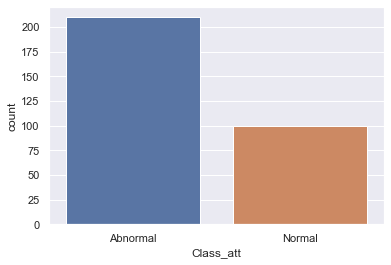

In [6]:
sns.countplot(data=df, x=df.Class_att)

# Univariable Analysis

C:\Users\Hp\anaconda3\envs\pytorch\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Col1'}>,
        <AxesSubplot:title={'center':'Col2'}>,
        <AxesSubplot:title={'center':'Col3'}>],
       [<AxesSubplot:title={'center':'Col4'}>,
        <AxesSubplot:title={'center':'Col5'}>,
        <AxesSubplot:title={'center':'Col6'}>],
       [<AxesSubplot:title={'center':'Col7'}>,
        <AxesSubplot:title={'center':'Col8'}>,
        <AxesSubplot:title={'center':'Col9'}>],
       [<AxesSubplot:title={'center':'Col10'}>,
        <AxesSubplot:title={'center':'Col11'}>,
        <AxesSubplot:title={'center':'Col12'}>]], dtype=object)

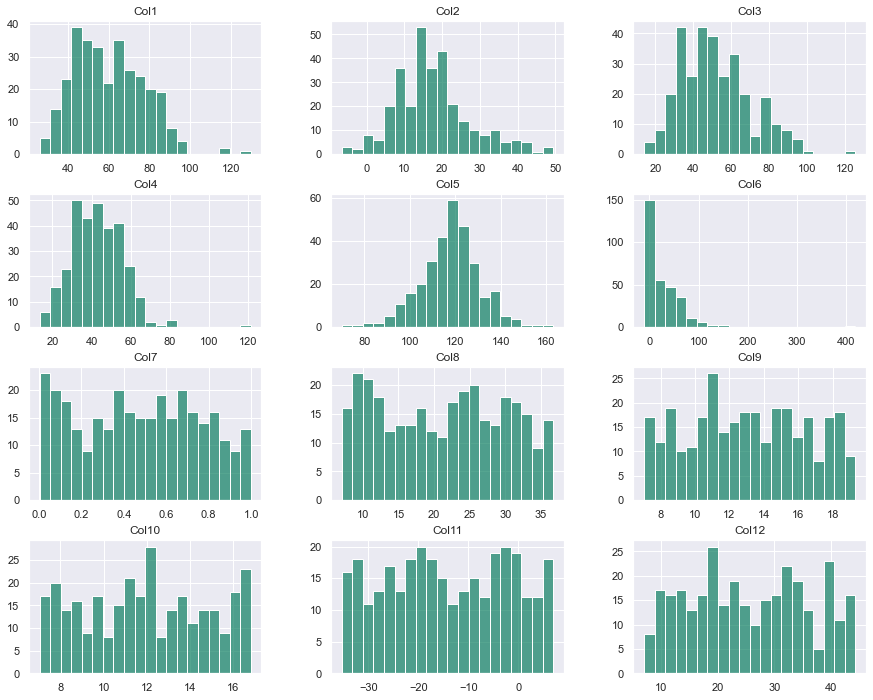

In [7]:
df.hist(figsize=(15,12),bins = 20, color="#007959AA")

<AxesSubplot:>

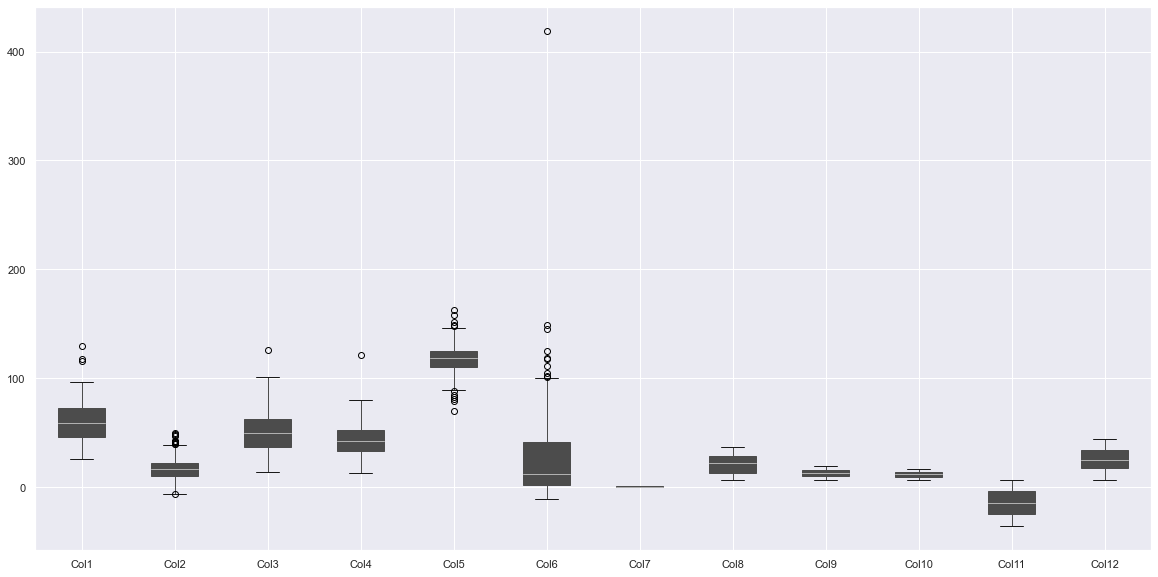

In [8]:
plt.subplots(figsize=(20,10))
df.boxplot(patch_artist=True)

<AxesSubplot:>

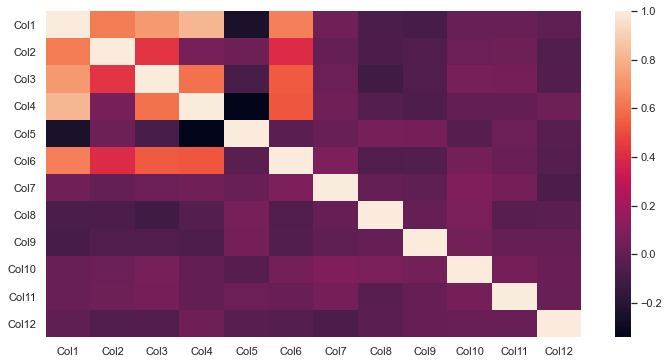

In [9]:
plt.subplots(figsize=(12,6))
sns.heatmap(df.corr())

# Detect and remove outlier

In [11]:
def detect_oulier(feature):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25 
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in feature if x < lower or x > upper]
    if len(outliers) > 0 :
        return True
    else:
        return False
    
def remove_outlier(feature):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25 
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in feature if x < lower or x > upper]
      
    median = feature.median()
    x = np.where((feature >upper) | (feature < lower), median, feature)
    return x

for feature in df:
    if feature != "Class_att":
        while True:
            if detect_oulier(df[feature]):
                df[feature] = remove_outlier(df[feature])
            else:
                break


<AxesSubplot:>

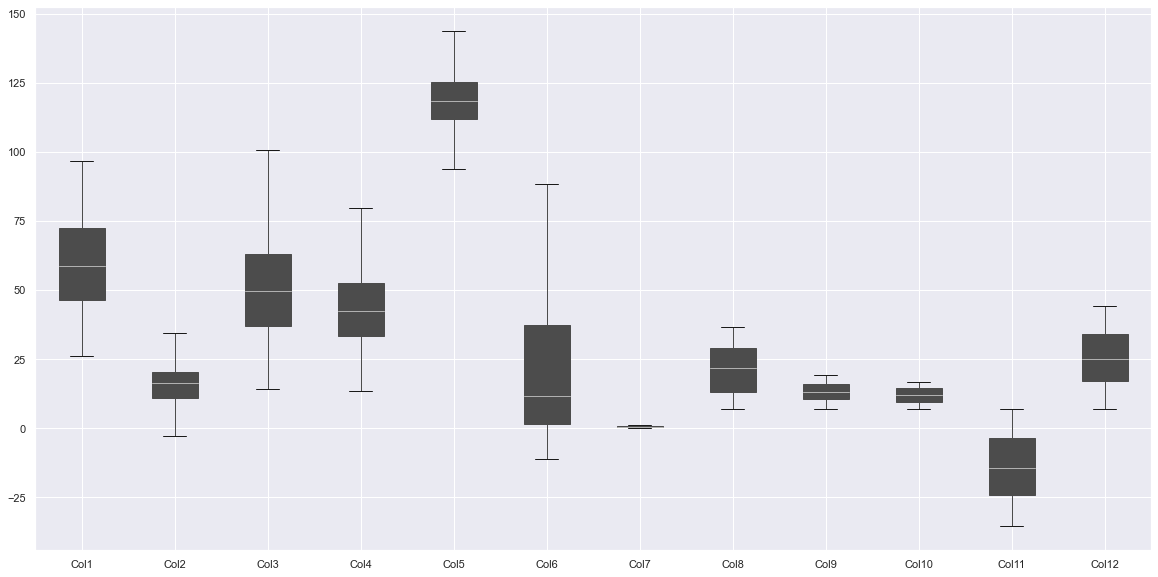

In [27]:
plt.subplots(figsize=(20,10))
df.boxplot(patch_artist=True)

# standardize dataset for neural network

In [12]:
X = df.iloc[:, :-1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(data = scaled_data, columns = X.columns)
scaled_df.head()
X = scaled_df.iloc[:, :]

In [13]:
label = df.Class_att
encoder = LabelEncoder()
label = encoder.fit_transform(label)

X = np.array(X.values)
y = np.array(label)

# Train test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
rate = 0.15/0.85
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=rate, random_state=1) 

# load dataset into batches for performance and speed  

In [15]:
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [16]:
batch_size = 3
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [17]:
input_size = len(X[0])

# Create neural network model

In [18]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_dim1, hidden_dim2, output_size, p_drop):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_size = output_size
        self.p_drop = p_drop
        
        self.fc1 = nn.Linear(input_size, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out_layer = nn.Linear(hidden_dim2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p_drop)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, batch_size):
        out = self.relu(self.fc1(x))
        out = self.batchnorm1(out)
        out = self.relu(self.fc2(out))
        out = self.batchnorm2(out)
        self.dropout(out)
        out = self.out_layer(out)
        
        return out
#         return out
    

# Train and test model

In [19]:
def test(nn_model, criterion):   
    nn_model.eval()
    num_correct = 0
    test_losses = []
    for x, y in test_loader:
        if(torch.cuda.is_available()):
            x = x.cuda()
            y = y.cuda()
        pred = nn_model(x.float(), 3)
        sigmoid = nn.Sigmoid()
        pred = sigmoid(pred)
        pred = torch.round(pred.squeeze())

        test_loss = criterion(pred, y.float())
        test_losses.append(test_loss.item())

        correct_tensor = pred.eq(y.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)


    test_acc = num_correct/len(test_loader.dataset)
    return test_acc

def train(nn_model, criterion, optimizer):
    nn_model.train()
    epoch_loss_train = 0
    for x, y in train_loader:
        if(torch.cuda.is_available()):
            x = x.cuda()
            y = y.cuda()
        nn_model.zero_grad()
        pred = nn_model(x.float(), 3)
        loss = criterion(pred, y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        epoch_loss_train = epoch_loss_train + loss.item()
    
    average_loss = epoch_loss_train/len(train_loader)
    return average_loss

# Fine tuning hyperparameter

In [20]:
from optuna.trial import Trial
def main_train(trial):
    params = {
        "lr": trial.suggest_loguniform("lr", 1e-4, 1e-2),
        "p_drop": trial.suggest_uniform("p_drop", 0.1, 0.7),
        "hidden_dim1": trial.suggest_int("hidden_dim1", 32, 256),
        "hidden_dim2": trial.suggest_int("hidden_dim2", 32, 256),
    }
    
    nn_model = NN(input_size,params["hidden_dim1"],params["hidden_dim2"],1, params["p_drop"])
#     nn_model = NN(input_size,64,64,1, params["p_drop"])
    if(torch.cuda.is_available()):
        nn_model = nn_model.cuda()

    epochs = 100
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=params["lr"])
    check = 0
    loss_training =[]
    acc_arr = []
    epoch_arr = []
    
    for epoch in range(epochs):
        train_loss = train(nn_model, criterion, optimizer)
#         acc = test(nn_model, criterion)
        
        print(f'epoch: {epoch+ 1}/{epochs}, train_loss: {train_loss}')
        epoch_arr.append(epoch)
        loss_training.append(train_loss)
    
    acc = test(nn_model, criterion)
    acc_arr.append(acc)
    print(f'test_accuracy: {acc}')
    return acc


In [21]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(main_train, n_trials=20)

[I 2021-06-01 16:15:27,352] A new study created in memory with name: no-name-59e06ce7-e9a2-4236-bf1f-4adcf9bf51d0


epoch: 1/100, train_loss: 0.6409006104287174
epoch: 2/100, train_loss: 0.5050095569135414
epoch: 3/100, train_loss: 0.5226336633786559
epoch: 4/100, train_loss: 0.48683689125917023
epoch: 5/100, train_loss: 0.45059591480013395
epoch: 6/100, train_loss: 0.47990612126886845
epoch: 7/100, train_loss: 0.45685829871541095
epoch: 8/100, train_loss: 0.4174435764240722
epoch: 9/100, train_loss: 0.4602092289779749
epoch: 10/100, train_loss: 0.49599296051181024
epoch: 11/100, train_loss: 0.4402871902825104
epoch: 12/100, train_loss: 0.45452550281253123
epoch: 13/100, train_loss: 0.47560972772124743
epoch: 14/100, train_loss: 0.4560900732047028
epoch: 15/100, train_loss: 0.4188473630282614
epoch: 16/100, train_loss: 0.44198302929807043
epoch: 17/100, train_loss: 0.4670744633509053
epoch: 18/100, train_loss: 0.44307129447244936
epoch: 19/100, train_loss: 0.42742134801422554
epoch: 20/100, train_loss: 0.5035626403987408
epoch: 21/100, train_loss: 0.396463180374768
epoch: 22/100, train_loss: 0.47496

[I 2021-06-01 16:16:15,561] Trial 0 finished with value: 0.8297872340425532 and parameters: {'lr': 0.0010946359156834456, 'p_drop': 0.22992729570447276, 'hidden_dim1': 195, 'hidden_dim2': 233}. Best is trial 0 with value: 0.8297872340425532.


epoch: 100/100, train_loss: 0.45439049130719567
test_accuracy: 0.8297872340425532
epoch: 1/100, train_loss: 0.6120483533789715
epoch: 2/100, train_loss: 0.5324505852121446
epoch: 3/100, train_loss: 0.5252063760740889
epoch: 4/100, train_loss: 0.5293480205453105
epoch: 5/100, train_loss: 0.5274851393575469
epoch: 6/100, train_loss: 0.5003375599367751
epoch: 7/100, train_loss: 0.5213484081129233
epoch: 8/100, train_loss: 0.5014403424122267
epoch: 9/100, train_loss: 0.5367339979857206
epoch: 10/100, train_loss: 0.4608508619583315
epoch: 11/100, train_loss: 0.5011526981575621
epoch: 12/100, train_loss: 0.5174354635592964
epoch: 13/100, train_loss: 0.4814080765677823
epoch: 14/100, train_loss: 0.5296359906593958
epoch: 15/100, train_loss: 0.45189920212659573
epoch: 16/100, train_loss: 0.5311650324405895
epoch: 17/100, train_loss: 0.527264780468411
epoch: 18/100, train_loss: 0.4618563401616282
epoch: 19/100, train_loss: 0.49565285842658746
epoch: 20/100, train_loss: 0.5157640317661895
epoch:

[I 2021-06-01 16:17:00,206] Trial 1 finished with value: 0.851063829787234 and parameters: {'lr': 0.0036477064192642953, 'p_drop': 0.34378548926916086, 'hidden_dim1': 65, 'hidden_dim2': 85}. Best is trial 1 with value: 0.851063829787234.


epoch: 100/100, train_loss: 0.42400567901010316
test_accuracy: 0.851063829787234
epoch: 1/100, train_loss: 0.664324524346739
epoch: 2/100, train_loss: 0.5257580238911841
epoch: 3/100, train_loss: 0.5527334457987713
epoch: 4/100, train_loss: 0.5073573210069703
epoch: 5/100, train_loss: 0.5148327104333374
epoch: 6/100, train_loss: 0.5133653534576297
epoch: 7/100, train_loss: 0.5104870208435588
epoch: 8/100, train_loss: 0.476272686643319
epoch: 9/100, train_loss: 0.513438279637032
epoch: 10/100, train_loss: 0.4670624156068597
epoch: 11/100, train_loss: 0.5287107916341888
epoch: 12/100, train_loss: 0.5090908663761284
epoch: 13/100, train_loss: 0.4907350581553247
epoch: 14/100, train_loss: 0.46745594839255017
epoch: 15/100, train_loss: 0.46795373836842674
epoch: 16/100, train_loss: 0.5112505608962642
epoch: 17/100, train_loss: 0.515237326009406
epoch: 18/100, train_loss: 0.5050694688947664
epoch: 19/100, train_loss: 0.46390173175475663
epoch: 20/100, train_loss: 0.4658979711174551
epoch: 21

[I 2021-06-01 16:17:44,343] Trial 2 finished with value: 0.8723404255319149 and parameters: {'lr': 0.003916904153087929, 'p_drop': 0.6891013741530321, 'hidden_dim1': 256, 'hidden_dim2': 242}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.5079700101373924
test_accuracy: 0.8723404255319149
epoch: 1/100, train_loss: 0.6934094486965073
epoch: 2/100, train_loss: 0.6165037026835812
epoch: 3/100, train_loss: 0.5878001186582777
epoch: 4/100, train_loss: 0.5771120501061281
epoch: 5/100, train_loss: 0.5325978145831161
epoch: 6/100, train_loss: 0.5602278854284022
epoch: 7/100, train_loss: 0.5350891904284557
epoch: 8/100, train_loss: 0.5143218216382794
epoch: 9/100, train_loss: 0.497945749718282
epoch: 10/100, train_loss: 0.49648943460649914
epoch: 11/100, train_loss: 0.49147916802515584
epoch: 12/100, train_loss: 0.4750281773093674
epoch: 13/100, train_loss: 0.49572099103695816
epoch: 14/100, train_loss: 0.4207146919022004
epoch: 15/100, train_loss: 0.4244297363070978
epoch: 16/100, train_loss: 0.4611629145219922
epoch: 17/100, train_loss: 0.4416979497505559
epoch: 18/100, train_loss: 0.4202852000792821
epoch: 19/100, train_loss: 0.46225288168837625
epoch: 20/100, train_loss: 0.47728815157380367
epoc

[I 2021-06-01 16:18:29,109] Trial 3 finished with value: 0.7659574468085106 and parameters: {'lr': 0.0002976428324051793, 'p_drop': 0.1421137423711169, 'hidden_dim1': 153, 'hidden_dim2': 51}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.39341194925105405
test_accuracy: 0.7659574468085106
epoch: 1/100, train_loss: 0.6154429920845561
epoch: 2/100, train_loss: 0.520962862090932
epoch: 3/100, train_loss: 0.5033060762410363
epoch: 4/100, train_loss: 0.47298214077535605
epoch: 5/100, train_loss: 0.5213930524057813
epoch: 6/100, train_loss: 0.49326548756410676
epoch: 7/100, train_loss: 0.4923274289402697
epoch: 8/100, train_loss: 0.4174650547405084
epoch: 9/100, train_loss: 0.5297921283377541
epoch: 10/100, train_loss: 0.5271821101713512
epoch: 11/100, train_loss: 0.4870495396769709
epoch: 12/100, train_loss: 0.4809214129216141
epoch: 13/100, train_loss: 0.47476570059855777
epoch: 14/100, train_loss: 0.5023821751690574
epoch: 15/100, train_loss: 0.48428662173036074
epoch: 16/100, train_loss: 0.4651796838475598
epoch: 17/100, train_loss: 0.450981224162711
epoch: 18/100, train_loss: 0.4533049895738562
epoch: 19/100, train_loss: 0.48908322252747083
epoch: 20/100, train_loss: 0.507253497114612
epoch

[I 2021-06-01 16:19:13,005] Trial 4 finished with value: 0.8297872340425532 and parameters: {'lr': 0.0032401272534205217, 'p_drop': 0.3468136361182632, 'hidden_dim1': 111, 'hidden_dim2': 102}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.4408718991196818
test_accuracy: 0.8297872340425532
epoch: 1/100, train_loss: 0.7014594516820378
epoch: 2/100, train_loss: 0.6599351883762412
epoch: 3/100, train_loss: 0.6190384150379233
epoch: 4/100, train_loss: 0.6107298135757446
epoch: 5/100, train_loss: 0.6289137125843101
epoch: 6/100, train_loss: 0.5681758887237973
epoch: 7/100, train_loss: 0.5309937892274724
epoch: 8/100, train_loss: 0.5835260999285512
epoch: 9/100, train_loss: 0.5308579417566458
epoch: 10/100, train_loss: 0.5305208594848713
epoch: 11/100, train_loss: 0.5244947353170978
epoch: 12/100, train_loss: 0.5531511998011006
epoch: 13/100, train_loss: 0.4978670005997022
epoch: 14/100, train_loss: 0.4906413714504904
epoch: 15/100, train_loss: 0.5171387013461854
epoch: 16/100, train_loss: 0.5131204273137782
epoch: 17/100, train_loss: 0.5033274044593176
epoch: 18/100, train_loss: 0.44588393811136484
epoch: 19/100, train_loss: 0.44523571493724984
epoch: 20/100, train_loss: 0.46619028349717456
epoch

[I 2021-06-01 16:19:56,412] Trial 5 finished with value: 0.7872340425531915 and parameters: {'lr': 0.0001797844384485496, 'p_drop': 0.44516344972824484, 'hidden_dim1': 210, 'hidden_dim2': 43}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.2976662175108989
test_accuracy: 0.7872340425531915
epoch: 1/100, train_loss: 0.6315584689792659
epoch: 2/100, train_loss: 0.50870582419965
epoch: 3/100, train_loss: 0.5150836116323868
epoch: 4/100, train_loss: 0.4503710267858373
epoch: 5/100, train_loss: 0.4922310512305962
epoch: 6/100, train_loss: 0.4952263984725707
epoch: 7/100, train_loss: 0.49308467759854263
epoch: 8/100, train_loss: 0.47079877131101155
epoch: 9/100, train_loss: 0.4859120279757513
epoch: 10/100, train_loss: 0.512951604814993
epoch: 11/100, train_loss: 0.4726830895783173
epoch: 12/100, train_loss: 0.5243467372428212
epoch: 13/100, train_loss: 0.4649984636861417
epoch: 14/100, train_loss: 0.4316661319591933
epoch: 15/100, train_loss: 0.47634799912985826
epoch: 16/100, train_loss: 0.4754974971421891
epoch: 17/100, train_loss: 0.4692284222692251
epoch: 18/100, train_loss: 0.5292537569896214
epoch: 19/100, train_loss: 0.5079969803078307
epoch: 20/100, train_loss: 0.4668374188347823
epoch: 2

[I 2021-06-01 16:20:39,487] Trial 6 finished with value: 0.8723404255319149 and parameters: {'lr': 0.0040179467117352746, 'p_drop': 0.23210472415792816, 'hidden_dim1': 251, 'hidden_dim2': 105}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.43766231265746885
test_accuracy: 0.8723404255319149
epoch: 1/100, train_loss: 0.6633336374329196
epoch: 2/100, train_loss: 0.5535588016112646
epoch: 3/100, train_loss: 0.5448757085121341
epoch: 4/100, train_loss: 0.4789669688584076
epoch: 5/100, train_loss: 0.4592317547649145
epoch: 6/100, train_loss: 0.4542078476192223
epoch: 7/100, train_loss: 0.4351703406622012
epoch: 8/100, train_loss: 0.4165672174551421
epoch: 9/100, train_loss: 0.45547767319819993
epoch: 10/100, train_loss: 0.46673196067826617
epoch: 11/100, train_loss: 0.48608403166549075
epoch: 12/100, train_loss: 0.416525287553668
epoch: 13/100, train_loss: 0.4055568140724467
epoch: 14/100, train_loss: 0.4226661988327073
epoch: 15/100, train_loss: 0.42996736740072566
epoch: 16/100, train_loss: 0.38416983533857596
epoch: 17/100, train_loss: 0.44314594028724563
epoch: 18/100, train_loss: 0.387720520194206
epoch: 19/100, train_loss: 0.3825442309284376
epoch: 20/100, train_loss: 0.436269201286551
epoc

[I 2021-06-01 16:21:23,047] Trial 7 finished with value: 0.7872340425531915 and parameters: {'lr': 0.0003968021560587179, 'p_drop': 0.33464395157331484, 'hidden_dim1': 186, 'hidden_dim2': 236}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.28919367304640925
test_accuracy: 0.7872340425531915
epoch: 1/100, train_loss: 0.6463150108853976
epoch: 2/100, train_loss: 0.5705424398183823
epoch: 3/100, train_loss: 0.5008325862387816
epoch: 4/100, train_loss: 0.5150274406704638
epoch: 5/100, train_loss: 0.4601933966494269
epoch: 6/100, train_loss: 0.48867049078560537
epoch: 7/100, train_loss: 0.46784659961445463
epoch: 8/100, train_loss: 0.434829147791283
epoch: 9/100, train_loss: 0.4556095913673441
epoch: 10/100, train_loss: 0.4173584115794963
epoch: 11/100, train_loss: 0.3812331547960639
epoch: 12/100, train_loss: 0.4108954043024116
epoch: 13/100, train_loss: 0.4021064787068301
epoch: 14/100, train_loss: 0.3901280627275507
epoch: 15/100, train_loss: 0.3701521111652255
epoch: 16/100, train_loss: 0.4323625633906987
epoch: 17/100, train_loss: 0.342454110013528
epoch: 18/100, train_loss: 0.3380317788364159
epoch: 19/100, train_loss: 0.38526220430826974
epoch: 20/100, train_loss: 0.4039709857509782
epoch:

[I 2021-06-01 16:22:06,384] Trial 8 finished with value: 0.7446808510638298 and parameters: {'lr': 0.000299383514658052, 'p_drop': 0.222349904321909, 'hidden_dim1': 251, 'hidden_dim2': 245}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.22643205844279793
test_accuracy: 0.7446808510638298
epoch: 1/100, train_loss: 0.6237075481977727
epoch: 2/100, train_loss: 0.5403145572377576
epoch: 3/100, train_loss: 0.49979947238332695
epoch: 4/100, train_loss: 0.5327719440683722
epoch: 5/100, train_loss: 0.5005479835801654
epoch: 6/100, train_loss: 0.49507043903900516
epoch: 7/100, train_loss: 0.5053126993589103
epoch: 8/100, train_loss: 0.5837526610121131
epoch: 9/100, train_loss: 0.49599038944062257
epoch: 10/100, train_loss: 0.5105844288029604
epoch: 11/100, train_loss: 0.5374240609299805
epoch: 12/100, train_loss: 0.4747005827311013
epoch: 13/100, train_loss: 0.48345083546721274
epoch: 14/100, train_loss: 0.5120727084577084
epoch: 15/100, train_loss: 0.46819755124549073
epoch: 16/100, train_loss: 0.5240236952280005
epoch: 17/100, train_loss: 0.5447614261777036
epoch: 18/100, train_loss: 0.48954917376654017
epoch: 19/100, train_loss: 0.5166371546478735
epoch: 20/100, train_loss: 0.49779085556252134


[I 2021-06-01 16:22:49,463] Trial 9 finished with value: 0.7659574468085106 and parameters: {'lr': 0.005831730629234525, 'p_drop': 0.1049143628529292, 'hidden_dim1': 66, 'hidden_dim2': 90}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.5071357207165824
test_accuracy: 0.7659574468085106
epoch: 1/100, train_loss: 0.6238898016098473
epoch: 2/100, train_loss: 0.5392864754216539
epoch: 3/100, train_loss: 0.5558889001193974
epoch: 4/100, train_loss: 0.4815627229917381
epoch: 5/100, train_loss: 0.47590256482362747
epoch: 6/100, train_loss: 0.4592636405593819
epoch: 7/100, train_loss: 0.4906821697950363
epoch: 8/100, train_loss: 0.5058875706874661
epoch: 9/100, train_loss: 0.5144946882501245
epoch: 10/100, train_loss: 0.4913576234442492
epoch: 11/100, train_loss: 0.5217490952668918
epoch: 12/100, train_loss: 0.4533030212753349
epoch: 13/100, train_loss: 0.48362483580907184
epoch: 14/100, train_loss: 0.45101582465900314
epoch: 15/100, train_loss: 0.5056805239162512
epoch: 16/100, train_loss: 0.48782259246541393
epoch: 17/100, train_loss: 0.4605190618894994
epoch: 18/100, train_loss: 0.45471441538797486
epoch: 19/100, train_loss: 0.48830841404075426
epoch: 20/100, train_loss: 0.4819602096039388
ep

[I 2021-06-01 16:23:33,006] Trial 10 finished with value: 0.8085106382978723 and parameters: {'lr': 0.0013250156941865343, 'p_drop': 0.6992880652722817, 'hidden_dim1': 136, 'hidden_dim2': 180}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.4278146519015233
test_accuracy: 0.8085106382978723
epoch: 1/100, train_loss: 0.6958965437693728
epoch: 2/100, train_loss: 0.5856433926771084
epoch: 3/100, train_loss: 0.5298897434129484
epoch: 4/100, train_loss: 0.5017285196938448
epoch: 5/100, train_loss: 0.5292047868586249
epoch: 6/100, train_loss: 0.45469363106207716
epoch: 7/100, train_loss: 0.4903453112993803
epoch: 8/100, train_loss: 0.5280886016165217
epoch: 9/100, train_loss: 0.4854626598664456
epoch: 10/100, train_loss: 0.44890370566604865
epoch: 11/100, train_loss: 0.5290524911963277
epoch: 12/100, train_loss: 0.4798069548689657
epoch: 13/100, train_loss: 0.48685221405078966
epoch: 14/100, train_loss: 0.4361645702479614
epoch: 15/100, train_loss: 0.5471684011734195
epoch: 16/100, train_loss: 0.5136206874416934
epoch: 17/100, train_loss: 0.5336124826636579
epoch: 18/100, train_loss: 0.5284063747773567
epoch: 19/100, train_loss: 0.49457016825262046
epoch: 20/100, train_loss: 0.47452702807883423
epo

[I 2021-06-01 16:24:16,649] Trial 11 finished with value: 0.7021276595744681 and parameters: {'lr': 0.007671665016687697, 'p_drop': 0.6762762496227899, 'hidden_dim1': 251, 'hidden_dim2': 156}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.4671458821329806
test_accuracy: 0.7021276595744681
epoch: 1/100, train_loss: 0.6154918726533651
epoch: 2/100, train_loss: 0.547281793008248
epoch: 3/100, train_loss: 0.5177234795151485
epoch: 4/100, train_loss: 0.5536571076760689
epoch: 5/100, train_loss: 0.47489144891086554
epoch: 6/100, train_loss: 0.5105385570269492
epoch: 7/100, train_loss: 0.48789998930361533
epoch: 8/100, train_loss: 0.503292590017534
epoch: 9/100, train_loss: 0.4805681745832165
epoch: 10/100, train_loss: 0.4978431761264801
epoch: 11/100, train_loss: 0.4646336499394642
epoch: 12/100, train_loss: 0.4809148291953736
epoch: 13/100, train_loss: 0.47502196362862986
epoch: 14/100, train_loss: 0.45169395495516557
epoch: 15/100, train_loss: 0.4502388697841929
epoch: 16/100, train_loss: 0.46869240468367934
epoch: 17/100, train_loss: 0.4913094681687653
epoch: 18/100, train_loss: 0.4784299411500494
epoch: 19/100, train_loss: 0.4587890114635229
epoch: 20/100, train_loss: 0.47525468070266974
epoc

[I 2021-06-01 16:24:59,888] Trial 12 finished with value: 0.851063829787234 and parameters: {'lr': 0.0022391548784201857, 'p_drop': 0.559185928231927, 'hidden_dim1': 254, 'hidden_dim2': 184}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.451396975459324
test_accuracy: 0.851063829787234
epoch: 1/100, train_loss: 0.6133224950689409
epoch: 2/100, train_loss: 0.593261533520288
epoch: 3/100, train_loss: 0.5523699669477841
epoch: 4/100, train_loss: 0.5294281201851037
epoch: 5/100, train_loss: 0.4858887369434039
epoch: 6/100, train_loss: 0.528586008068588
epoch: 7/100, train_loss: 0.49509850910140407
epoch: 8/100, train_loss: 0.5215288964617584
epoch: 9/100, train_loss: 0.511562921675957
epoch: 10/100, train_loss: 0.5260649321393834
epoch: 11/100, train_loss: 0.4592321195329229
epoch: 12/100, train_loss: 0.47625058537556064
epoch: 13/100, train_loss: 0.516186544050773
epoch: 14/100, train_loss: 0.5078920141483346
epoch: 15/100, train_loss: 0.48239613396839964
epoch: 16/100, train_loss: 0.5204833346522517
epoch: 17/100, train_loss: 0.5068251793790195
epoch: 18/100, train_loss: 0.4912186795845628
epoch: 19/100, train_loss: 0.4871770151787334
epoch: 20/100, train_loss: 0.4779652575444844
epoch: 21/1

[I 2021-06-01 16:25:43,174] Trial 13 finished with value: 0.8297872340425532 and parameters: {'lr': 0.009938544004038414, 'p_drop': 0.49809936285914425, 'hidden_dim1': 223, 'hidden_dim2': 124}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.4395168216692077
test_accuracy: 0.8297872340425532
epoch: 1/100, train_loss: 0.6274569502307309
epoch: 2/100, train_loss: 0.545538691803813
epoch: 3/100, train_loss: 0.48983607658495504
epoch: 4/100, train_loss: 0.4808031714314388
epoch: 5/100, train_loss: 0.5283166244626045
epoch: 6/100, train_loss: 0.4910355559550226
epoch: 7/100, train_loss: 0.47128144667173427
epoch: 8/100, train_loss: 0.5194682277118167
epoch: 9/100, train_loss: 0.43647399441235596
epoch: 10/100, train_loss: 0.42978332944524783
epoch: 11/100, train_loss: 0.5055389995169308
epoch: 12/100, train_loss: 0.4387080332574745
epoch: 13/100, train_loss: 0.4656671152657105
epoch: 14/100, train_loss: 0.43827012088149786
epoch: 15/100, train_loss: 0.47035821232323843
epoch: 16/100, train_loss: 0.468337570110129
epoch: 17/100, train_loss: 0.45000424039446646
epoch: 18/100, train_loss: 0.41841617826786304
epoch: 19/100, train_loss: 0.45818042946565485
epoch: 20/100, train_loss: 0.44551555450177854


[I 2021-06-01 16:26:26,586] Trial 14 finished with value: 0.8085106382978723 and parameters: {'lr': 0.0020292257062588808, 'p_drop': 0.5800591570524903, 'hidden_dim1': 232, 'hidden_dim2': 201}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.4514147768624955
test_accuracy: 0.8085106382978723
epoch: 1/100, train_loss: 0.5835938565433025
epoch: 2/100, train_loss: 0.5659033356027471
epoch: 3/100, train_loss: 0.53646346874949
epoch: 4/100, train_loss: 0.4625818992240561
epoch: 5/100, train_loss: 0.5049554688028164
epoch: 6/100, train_loss: 0.5407326994463801
epoch: 7/100, train_loss: 0.5490250951713986
epoch: 8/100, train_loss: 0.5098381349816918
epoch: 9/100, train_loss: 0.4927566830172307
epoch: 10/100, train_loss: 0.47106771926499075
epoch: 11/100, train_loss: 0.44456183206703925
epoch: 12/100, train_loss: 0.4831136705664297
epoch: 13/100, train_loss: 0.5105859850947227
epoch: 14/100, train_loss: 0.43550981312162346
epoch: 15/100, train_loss: 0.5512355085876253
epoch: 16/100, train_loss: 0.5197416818183329
epoch: 17/100, train_loss: 0.4681356434399883
epoch: 18/100, train_loss: 0.4852562661593159
epoch: 19/100, train_loss: 0.5114974362982644
epoch: 20/100, train_loss: 0.518083931464288
epoch: 2

[I 2021-06-01 16:27:09,793] Trial 15 finished with value: 0.8723404255319149 and parameters: {'lr': 0.005141791990950532, 'p_drop': 0.22661651442547057, 'hidden_dim1': 171, 'hidden_dim2': 138}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.45516786103447276
test_accuracy: 0.8723404255319149
epoch: 1/100, train_loss: 0.5802125040855672
epoch: 2/100, train_loss: 0.5453906719469361
epoch: 3/100, train_loss: 0.525574340381556
epoch: 4/100, train_loss: 0.4930917685851455
epoch: 5/100, train_loss: 0.5030634672277503
epoch: 6/100, train_loss: 0.4621723974123597
epoch: 7/100, train_loss: 0.4715671907696459
epoch: 8/100, train_loss: 0.48196778746528757
epoch: 9/100, train_loss: 0.49392810018940103
epoch: 10/100, train_loss: 0.47031202757110196
epoch: 11/100, train_loss: 0.3919057673257258
epoch: 12/100, train_loss: 0.46224484458151793
epoch: 13/100, train_loss: 0.4266565369649066
epoch: 14/100, train_loss: 0.4345799210584826
epoch: 15/100, train_loss: 0.4377111194448339
epoch: 16/100, train_loss: 0.4145170261876451
epoch: 17/100, train_loss: 0.4076334760627813
epoch: 18/100, train_loss: 0.4100115892166893
epoch: 19/100, train_loss: 0.43367653355623287
epoch: 20/100, train_loss: 0.4067258942975766
epo

[I 2021-06-01 16:27:52,859] Trial 16 finished with value: 0.7872340425531915 and parameters: {'lr': 0.000635266062954074, 'p_drop': 0.17422364435483487, 'hidden_dim1': 108, 'hidden_dim2': 68}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.3462246596916682
test_accuracy: 0.7872340425531915
epoch: 1/100, train_loss: 0.6403976420147551
epoch: 2/100, train_loss: 0.5490554175857041
epoch: 3/100, train_loss: 0.5228901639218546
epoch: 4/100, train_loss: 0.5214341598459415
epoch: 5/100, train_loss: 0.5448084876148237
epoch: 6/100, train_loss: 0.5273480647140079
epoch: 7/100, train_loss: 0.5752450185310509
epoch: 8/100, train_loss: 0.533411875160204
epoch: 9/100, train_loss: 0.5069777152708007
epoch: 10/100, train_loss: 0.5443827238761716
epoch: 11/100, train_loss: 0.49692205391410327
epoch: 12/100, train_loss: 0.4753733300603926
epoch: 13/100, train_loss: 0.5277110010178553
epoch: 14/100, train_loss: 0.4862021745906936
epoch: 15/100, train_loss: 0.4831431817470325
epoch: 16/100, train_loss: 0.5146510279220011
epoch: 17/100, train_loss: 0.4608875311290224
epoch: 18/100, train_loss: 0.5287863419701656
epoch: 19/100, train_loss: 0.4478737572208047
epoch: 20/100, train_loss: 0.5093520108558651
epoch: 2

[I 2021-06-01 16:28:36,065] Trial 17 finished with value: 0.8085106382978723 and parameters: {'lr': 0.009616417924230146, 'p_drop': 0.6270904150632229, 'hidden_dim1': 233, 'hidden_dim2': 112}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.438382593397465
test_accuracy: 0.8085106382978723
epoch: 1/100, train_loss: 0.6485889882056249
epoch: 2/100, train_loss: 0.5407156389620569
epoch: 3/100, train_loss: 0.5025832136679027
epoch: 4/100, train_loss: 0.48671977325446075
epoch: 5/100, train_loss: 0.4499254306881792
epoch: 6/100, train_loss: 0.5099519630894065
epoch: 7/100, train_loss: 0.5071854590334826
epoch: 8/100, train_loss: 0.4971239276023375
epoch: 9/100, train_loss: 0.5027407142333686
epoch: 10/100, train_loss: 0.5277189282286499
epoch: 11/100, train_loss: 0.5136869498011138
epoch: 12/100, train_loss: 0.5351059198793437
epoch: 13/100, train_loss: 0.49354565474722123
epoch: 14/100, train_loss: 0.5604001191548176
epoch: 15/100, train_loss: 0.5067083898724781
epoch: 16/100, train_loss: 0.5120891340904765
epoch: 17/100, train_loss: 0.4645186751149595
epoch: 18/100, train_loss: 0.5016057919710875
epoch: 19/100, train_loss: 0.5177787273294396
epoch: 20/100, train_loss: 0.5089545069883267
epoch: 

[I 2021-06-01 16:29:19,701] Trial 18 finished with value: 0.851063829787234 and parameters: {'lr': 0.005474035931977732, 'p_drop': 0.28385168145897377, 'hidden_dim1': 168, 'hidden_dim2': 141}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.45221663131895995
test_accuracy: 0.851063829787234
epoch: 1/100, train_loss: 0.6636151423056921
epoch: 2/100, train_loss: 0.573300669176711
epoch: 3/100, train_loss: 0.5091862879279587
epoch: 4/100, train_loss: 0.5057669198140502
epoch: 5/100, train_loss: 0.49477718744633925
epoch: 6/100, train_loss: 0.4165669236746099
epoch: 7/100, train_loss: 0.514193444719745
epoch: 8/100, train_loss: 0.5159038274238507
epoch: 9/100, train_loss: 0.4456779325587882
epoch: 10/100, train_loss: 0.40069161753894555
epoch: 11/100, train_loss: 0.5132886127879223
epoch: 12/100, train_loss: 0.45687296945187783
epoch: 13/100, train_loss: 0.4711695807054639
epoch: 14/100, train_loss: 0.46609374503087664
epoch: 15/100, train_loss: 0.4964232052055498
epoch: 16/100, train_loss: 0.4640873060044315
epoch: 17/100, train_loss: 0.5338123923995428
epoch: 18/100, train_loss: 0.4573173149385386
epoch: 19/100, train_loss: 0.5187620690299405
epoch: 20/100, train_loss: 0.4553536268778973
epoch:

[I 2021-06-01 16:30:03,080] Trial 19 finished with value: 0.8297872340425532 and parameters: {'lr': 0.001584662078626943, 'p_drop': 0.4482899782055272, 'hidden_dim1': 98, 'hidden_dim2': 215}. Best is trial 2 with value: 0.8723404255319149.


epoch: 100/100, train_loss: 0.47490423503849244
test_accuracy: 0.8297872340425532


In [26]:
# sns.relplot(x=epoch_arr, y=loss_training, kind="line")

# Model has 87% accuracy

In [23]:
print(study.best_trial, study.best_params)

FrozenTrial(number=2, values=[0.8723404255319149], datetime_start=datetime.datetime(2021, 6, 1, 16, 17, 0, 207486), datetime_complete=datetime.datetime(2021, 6, 1, 16, 17, 44, 343454), params={'lr': 0.003916904153087929, 'p_drop': 0.6891013741530321, 'hidden_dim1': 256, 'hidden_dim2': 242}, distributions={'lr': LogUniformDistribution(high=0.01, low=0.0001), 'p_drop': UniformDistribution(high=0.7, low=0.1), 'hidden_dim1': IntUniformDistribution(high=256, low=32, step=1), 'hidden_dim2': IntUniformDistribution(high=256, low=32, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None) {'lr': 0.003916904153087929, 'p_drop': 0.6891013741530321, 'hidden_dim1': 256, 'hidden_dim2': 242}
